In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import math
from itertools import chain
import itertools
import random
import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd.function import Function
import torch.nn.utils.prune as prune
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fftshift

from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torch import nn, einsum
import logging
from functools import partial
from collections import OrderedDict
import seaborn as sns
import matplotlib as mp
import time
from scipy.signal import savgol_filter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler



import importlib
import sys

sys.path.append('../src')
from utils import data_handler
from utils import benchmark
from utils import visualisation
from utils.models.VQ_VAE import Model
importlib.reload(data_handler) # to allow modification of the script without restarting the whole session

import json
from tqdm import tqdm


# instead, we plug in our OWN datasets

In [ ]:
suggested_genes_file_1 = '../../data/PD_genes_of_interest/signif_de_Disease_status_IDIOPATHIC_PD_01.tsv'
suggested_genes_file_2 = '../../data/PD_genes_of_interest/signif_de_PD_DIAGNOSIS_0.1.tsv'

not applying any filtering over phases
retaining all patient who have at least passed the Base Line Visit...
loading samples...
loaded 4445 samples
selecting genes based on median absolute deviation threshold:  5 ...
min MAD 0.0
max MAD 4194.0


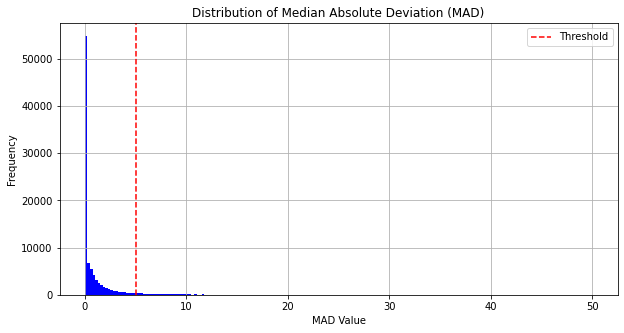

removing 89395 genes under the MAD threshold from the dataset
number of genes selected :  5914
log(1 + x) transformation...
scaling to [0, 1]...
number of seq in the dataset : 4445
keeping sample as is, no conversion to time series
not applying any filtering over phases
retaining all patient who have at least passed the Base Line Visit...
loading samples...
loaded 4445 samples
retriving symbols for genes
selecting genes based on median absolute deviation threshold:  2 ...
min MAD 0.0
max MAD 4192.0999999999985


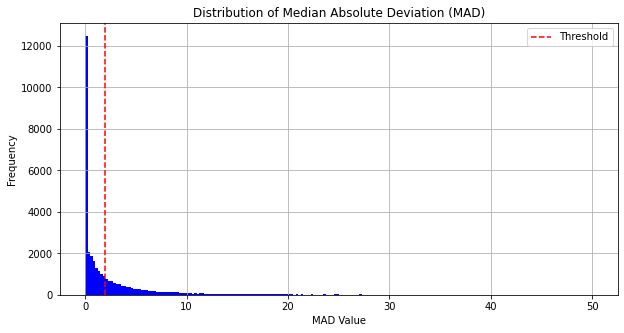

removing 22641 genes under the MAD threshold from the dataset
number of genes selected :  11928
log(1 + x) transformation...
scaling to [0, 1]...
number of seq in the dataset : 4445
keeping sample as is, no conversion to time series


In [3]:
# experiment 1
x_train, filenames, n_genes, gene_names = data_handler.generate_dataset_transcripts(
    feature_selection_threshold = 5, 
    gene_selection_file = None)

data_1 = np.concatenate(list(x_train.as_numpy_iterator()), axis=0)

feature_num_1 = data_1.shape[1]
data_num_1 = data_1.shape[0]
dat_1 = data_1.reshape(-1,1,feature_num_1)


x_train, filenames, n_genes, gene_names = data_handler.generate_dataset(
    feature_selection_threshold = 2, 
    gene_selection_file = None)

data_2 = np.concatenate(list(x_train.as_numpy_iterator()), axis=0)

feature_num_2 = data_2.shape[1]
data_num_2 = data_2.shape[0]
dat_2 = data_2.reshape(-1,1,feature_num_2)


In [ ]:
# experiment 2
x_train, filenames, n_genes, gene_names = data_handler.generate_dataset_transcripts(
    feature_selection_threshold = 0, 
    gene_selection_file = suggested_genes_file_1)

data_1 = np.concatenate(list(x_train.as_numpy_iterator()), axis=0)

feature_num_1 = data_1.shape[1]
data_num_1 = data_1.shape[0]
dat_1 = data_1.reshape(-1,1,feature_num_1)


x_train, filenames, n_genes, gene_names = data_handler.generate_dataset(
    feature_selection_threshold = 0, 
    gene_selection_file = suggested_genes_file_1)

data_2 = np.concatenate(list(x_train.as_numpy_iterator()), axis=0)

feature_num_2 = data_2.shape[1]
data_num_2 = data_2.shape[0]
dat_2 = data_2.reshape(-1,1,feature_num_2)


In [ ]:
# experiment 3
x_train, filenames, n_genes, gene_names = data_handler.generate_dataset_transcripts(
    feature_selection_threshold = 0, 
    gene_selection_file = suggested_genes_file_2)

data_1 = np.concatenate(list(x_train.as_numpy_iterator()), axis=0)

feature_num_1 = data_1.shape[1]
data_num_1 = data_1.shape[0]
dat_1 = data_1.reshape(-1,1,feature_num_1)


x_train, filenames, n_genes, gene_names = data_handler.generate_dataset(
    feature_selection_threshold = 0, 
    gene_selection_file = suggested_genes_file_2)

data_2 = np.concatenate(list(x_train.as_numpy_iterator()), axis=0)

feature_num_2 = data_2.shape[1]
data_num_2 = data_2.shape[0]
dat_2 = data_2.reshape(-1,1,feature_num_2)


## End of experiment choice

In [4]:
class Mydatasets(torch.utils.data.Dataset):
    def __init__(self, data1, data2 ,transform = None):
        self.transform = transform
        self.data1 = data1
        self.data2 = data2
        self.datanum = len(data1)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        
        out_data1 = torch.tensor(self.data1[idx]).float()
        out_data2 = torch.tensor(self.data2[idx]).float()
        if self.transform:
            out_data1 = self.transform(out_data1)
            out_data2 = self.transform(out_data2)

        return out_data1,out_data2

In [5]:
train_1, test_1 = train_test_split(dat_1, test_size = 0.1,random_state = 66)
print('train_data_1:',len(train_1))
print('test_data_1:',len(test_1))

train_2, test_2 = train_test_split(dat_2, test_size = 0.1,random_state = 66)
print('train_data_2:',len(train_2))
print('test_data_2:',len(test_2))

train_data_set = Mydatasets(data1 = train_1, data2 = train_2)
test_data_set = Mydatasets(data1 = test_1, data2 = test_2)

train_dataloader = torch.utils.data.DataLoader(train_data_set, batch_size = 256, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data_set, batch_size = 64, shuffle=False)

train_data_1: 4000
test_data_1: 445
train_data_2: 4000
test_data_2: 445


In [6]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = rearrange(inputs, 'b c l -> b l c')
        inputs = inputs.contiguous()
        #inputs = inputs.permute(0, 2, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        quantized = rearrange(quantized, 'b c l -> b l c')
        quantized = quantized.contiguous()
        
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        #return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings
        return loss, quantized, perplexity, encodings
    
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost
        
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()
        
        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = rearrange(inputs, 'b c l -> b l c')
        inputs = inputs.contiguous()
        #inputs = inputs.permute(0, 2, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)
            
            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)
            
            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)
            
            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss
        
        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        quantized = rearrange(quantized, 'b c l -> b l c')
        quantized = quantized.contiguous()
        
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
               
        # convert quantized from BHWC -> BCHW
        #return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings
        return loss, quantized, perplexity, encodings   

In [7]:
class ResidualStack(nn.Module):
    def __init__(self, encoder_dim):
        super(ResidualStack, self).__init__()
        
        self.block = nn.Sequential(
            nn.Linear(encoder_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, encoder_dim),
            nn.ReLU()
        )
    
    def forward(self, x):
        return x + self.block(x)
    
class Encoder(nn.Module):
    def __init__(self, input_size_1, encoder_dim, dropout):
        super(Encoder, self).__init__()

        self.lay1 = nn.Sequential(
            nn.Linear(input_size_1, 2048),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        self.lay2 = nn.Sequential(
            nn.Linear(2048, encoder_dim),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        self._residual_stack = ResidualStack(encoder_dim)

    def forward(self, inputs_1):
        x_1 = self.lay1(inputs_1)
        x_1 = self.lay2(x_1)
        x_1 = self._residual_stack(x_1)
        return x_1

    def forward(self, inputs_2):
        x_1 = self.lay1(inputs_2)
        x_1 = self.lay2(x_1)
        x_1 = self._residual_stack(x_1)
        return x_1

class Decoder(nn.Module):
    def __init__(self, num_embeddings, input_size_1, encoder_dim, dropout):
        super(Decoder, self).__init__()
        
        self.lay0 = nn.Sequential(
            nn.Linear(num_embeddings, encoder_dim),
            nn.GELU(),
            nn.Dropout(dropout)
        )

        self._residual_stack = ResidualStack(encoder_dim)
        
        self.lay1 = nn.Sequential(
            nn.Linear(encoder_dim, 2048),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        
        self.lay2 = nn.Sequential(
            nn.Linear(2048, input_size_1),
            nn.GELU(),
            nn.Dropout(dropout)
        )

    def forward(self, inputs):
        x = self.lay0(inputs)
        x = self._residual_stack(x)
        x_1 = self.lay1(x)
        x_1 = self.lay2(x_1)
        return x_1

In [8]:
class Model(nn.Module):
    def __init__(self, num_classes, input_size_1, input_size_2, encoder_dim_b, encoder_dim_t, num_embeddings_b, num_embeddings_t, embedding_dim_b, embedding_dim_t, commitment_cost, dropout, decay=0):
        super(Model, self).__init__()
        
        self._encoder_b = Encoder(input_size_1, encoder_dim_b, dropout)
        self._encoder_b2 = Encoder(input_size_2, encoder_dim_b, dropout)
        self._encoder_t = Encoder(encoder_dim_b, encoder_dim_t, dropout)
        
        self._pre_vq_conv_b = nn.Linear(encoder_dim_b, num_embeddings_b)
        self._pre_vq_conv_t = nn.Linear(encoder_dim_t, num_embeddings_t)
        
        if decay > 0.0:
            self._vq_vae_b = VectorQuantizerEMA(num_embeddings_b, embedding_dim_b, commitment_cost, decay)
            self._vq_vae_t = VectorQuantizerEMA(num_embeddings_t, embedding_dim_t, commitment_cost, decay)
        else:
            self._vq_vae_b = VectorQuantizer(num_embeddings_b, embedding_dim_b, commitment_cost)
            self._vq_vae_t = VectorQuantizer(num_embeddings_t, embedding_dim_t, commitment_cost)
        
        self._upsample = nn.Linear(num_embeddings_t, num_embeddings_b)
        
        self._decoder_t = Decoder(num_embeddings_t, encoder_dim_b, encoder_dim_t, dropout)   
        self._decoder_b = Decoder(num_embeddings_b, input_size_1, encoder_dim_b, dropout)
        self._decoder_b2 = Decoder(num_embeddings_b, input_size_2, encoder_dim_b, dropout)
        

    def forward(self, x1, x2):
        #Top level
        z_b = self._encoder_b(x1)
        z_t = self._encoder_t(z_b)
        z_t = self._pre_vq_conv_t(z_t)
        vq_loss_t, quantized_t, perplexity_t, _ = self._vq_vae_t(z_t)
        recon_t = self._decoder_t(quantized_t)
        
        #Bottom level
        z_b2 = self._encoder_b2(x2)
        z_final = z_b + z_b2 + recon_t
        z_final = self._pre_vq_conv_b(z_final)
        vq_loss_b, quantized_b, perplexity_b, _ = self._vq_vae_b(z_final)
        recon_b = self._decoder_b(quantized_b + self._upsample(quantized_t))
        recon_b2 = self._decoder_b2(quantized_b + self._upsample(quantized_t))
        variance_z_b = torch.var(z_b)
        return vq_loss_b, vq_loss_t, recon_b, recon_b2, recon_t, z_b, z_final, quantized_b, perplexity_b, variance_z_b

## Preping labels

In [9]:
metadata_path = "../../METADATA_200123.xlsx"

meta_data = pd.read_excel(metadata_path, header = 1, usecols = range(1,10) )
patient_ids = [int(name.split(".")[1]) for name in filenames]

# Create a dictionary to map 'Patient Number' to 'Disease Status'
patient_disease_status = dict(zip(meta_data['Patient Number'], meta_data['Disease Status']))

label = [patient_disease_status.get(patient_id, None) for patient_id in patient_ids]
num_classes = len(pd.Series(label).unique())

In [10]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device("mps")

VQ_VAE = Model(
            dropout = 0.0,
            num_classes = num_classes,
            input_size_1 = feature_num_1,
            input_size_2 = feature_num_2,
            encoder_dim_b = 64,
            encoder_dim_t = 32,
            num_embeddings_b = 64,
            num_embeddings_t = 32,
            embedding_dim_b = 64,
            embedding_dim_t = 32, 
            commitment_cost = 1
           ).to(DEVICE)

Classifier_loss = torch.nn.CrossEntropyLoss()
optimizer = optim.AdamW(VQ_VAE.parameters(), lr=1e-4, amsgrad=False)
data_variance_1 = np.var(dat_1)
data_variance_2 = np.var(dat_2)

#VQ_VAE.load_state_dict(torch.load('VQ_2_disc'),strict=False)
print(DEVICE)

mps


we need a proper training function


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100],Recon Error: 16.1191, Perplexity: 1.1464
Epoch [1/100],Recon Error: 15.0150, Perplexity: 1.0000
Epoch [1/100],Recon Error: 13.5784, Perplexity: 1.0467


  1%|          | 1/100 [00:05<09:29,  5.75s/it]

Epoch [2/100],Recon Error: 12.0984, Perplexity: 1.0000
Epoch [2/100],Recon Error: 11.3758, Perplexity: 1.0000
Epoch [2/100],Recon Error: 9.9550, Perplexity: 1.0000


  2%|▏         | 2/100 [00:09<07:19,  4.48s/it]

Epoch [3/100],Recon Error: 8.0846, Perplexity: 1.0000
Epoch [3/100],Recon Error: 6.3210, Perplexity: 1.0000
Epoch [3/100],Recon Error: 4.7124, Perplexity: 1.0000


  3%|▎         | 3/100 [00:12<06:37,  4.10s/it]

Epoch [4/100],Recon Error: 3.0357, Perplexity: 1.0000
Epoch [4/100],Recon Error: 2.1959, Perplexity: 1.0000
Epoch [4/100],Recon Error: 2.0917, Perplexity: 1.0000


  4%|▍         | 4/100 [00:16<06:25,  4.01s/it]

Epoch [5/100],Recon Error: 1.9624, Perplexity: 1.0000
Epoch [5/100],Recon Error: 1.9083, Perplexity: 1.0000
Epoch [5/100],Recon Error: 1.8777, Perplexity: 1.0000


  5%|▌         | 5/100 [00:20<06:12,  3.92s/it]

Epoch [6/100],Recon Error: 1.7945, Perplexity: 1.0000
Epoch [6/100],Recon Error: 1.7557, Perplexity: 1.0000
Epoch [6/100],Recon Error: 1.7529, Perplexity: 1.9705


  6%|▌         | 6/100 [00:24<06:05,  3.89s/it]

Epoch [7/100],Recon Error: 1.7079, Perplexity: 2.2858
Epoch [7/100],Recon Error: 1.6386, Perplexity: 2.3200
Epoch [7/100],Recon Error: 1.4867, Perplexity: 2.5496


  7%|▋         | 7/100 [00:28<05:52,  3.78s/it]

Epoch [8/100],Recon Error: 1.5589, Perplexity: 1.8309
Epoch [8/100],Recon Error: 1.4613, Perplexity: 1.7317
Epoch [8/100],Recon Error: 1.5120, Perplexity: 1.9031


  8%|▊         | 8/100 [00:31<05:38,  3.68s/it]

Epoch [9/100],Recon Error: 1.4506, Perplexity: 1.9589
Epoch [9/100],Recon Error: 1.4193, Perplexity: 1.9214
Epoch [9/100],Recon Error: 1.2830, Perplexity: 1.9079


  9%|▉         | 9/100 [00:34<05:27,  3.60s/it]

Epoch [10/100],Recon Error: 1.2454, Perplexity: 1.8933
Epoch [10/100],Recon Error: 1.2203, Perplexity: 1.9803
Epoch [10/100],Recon Error: 1.2701, Perplexity: 1.9985


 10%|█         | 10/100 [00:38<05:28,  3.65s/it]

Epoch [11/100],Recon Error: 1.2501, Perplexity: 1.9939
Epoch [11/100],Recon Error: 1.2536, Perplexity: 1.9378
Epoch [11/100],Recon Error: 1.0912, Perplexity: 1.9214


 11%|█         | 11/100 [00:42<05:25,  3.65s/it]

Epoch [12/100],Recon Error: 1.0756, Perplexity: 1.8776
Epoch [12/100],Recon Error: 1.1363, Perplexity: 1.9339
Epoch [12/100],Recon Error: 1.1075, Perplexity: 1.9803


 12%|█▏        | 12/100 [00:46<05:30,  3.75s/it]

Epoch [13/100],Recon Error: 1.0042, Perplexity: 1.8830
Epoch [13/100],Recon Error: 0.9642, Perplexity: 1.8933
Epoch [13/100],Recon Error: 0.9605, Perplexity: 1.9079


 13%|█▎        | 13/100 [00:50<05:35,  3.85s/it]

Epoch [14/100],Recon Error: 0.9012, Perplexity: 1.7622
Epoch [14/100],Recon Error: 0.8353, Perplexity: 1.7980


 14%|█▍        | 14/100 [00:54<05:25,  3.79s/it]

Epoch [14/100],Recon Error: 0.8760, Perplexity: 1.9489
Epoch [15/100],Recon Error: 0.7677, Perplexity: 1.9649
Epoch [15/100],Recon Error: 0.8601, Perplexity: 1.9298
Epoch [15/100],Recon Error: 0.8581, Perplexity: 1.8371


 15%|█▌        | 15/100 [00:58<05:35,  3.95s/it]

Epoch [16/100],Recon Error: 0.9241, Perplexity: 1.9678
Epoch [16/100],Recon Error: 0.7545, Perplexity: 1.8666
Epoch [16/100],Recon Error: 0.7090, Perplexity: 1.9339


 16%|█▌        | 16/100 [01:02<05:39,  4.05s/it]

Epoch [17/100],Recon Error: 0.7369, Perplexity: 1.8882
Epoch [17/100],Recon Error: 0.8047, Perplexity: 1.9416
Epoch [17/100],Recon Error: 0.7380, Perplexity: 1.9961


 17%|█▋        | 17/100 [01:06<05:33,  4.02s/it]

Epoch [18/100],Recon Error: 0.8289, Perplexity: 1.9649
Epoch [18/100],Recon Error: 0.8164, Perplexity: 1.9985


 18%|█▊        | 18/100 [01:10<05:17,  3.88s/it]

Epoch [18/100],Recon Error: 0.7520, Perplexity: 1.9489
Epoch [19/100],Recon Error: 0.6727, Perplexity: 1.9678
Epoch [19/100],Recon Error: 0.6536, Perplexity: 1.9125
Epoch [19/100],Recon Error: 0.7209, Perplexity: 1.9170


 19%|█▉        | 19/100 [01:13<05:07,  3.80s/it]

Epoch [20/100],Recon Error: 0.7187, Perplexity: 1.9731
Epoch [20/100],Recon Error: 0.7031, Perplexity: 1.8830
Epoch [20/100],Recon Error: 0.7517, Perplexity: 1.9453


 20%|██        | 20/100 [01:17<05:00,  3.76s/it]

Epoch [21/100],Recon Error: 0.6600, Perplexity: 1.8776
Epoch [21/100],Recon Error: 0.6768, Perplexity: 1.9489


 21%|██        | 21/100 [01:20<04:52,  3.70s/it]

Epoch [21/100],Recon Error: 0.7162, Perplexity: 1.9995
Epoch [22/100],Recon Error: 0.6545, Perplexity: 1.7395
Epoch [22/100],Recon Error: 0.7340, Perplexity: 1.9844
Epoch [22/100],Recon Error: 0.7022, Perplexity: 1.9803


 22%|██▏       | 22/100 [01:24<04:47,  3.69s/it]

Epoch [23/100],Recon Error: 0.7087, Perplexity: 1.7910
Epoch [23/100],Recon Error: 0.7761, Perplexity: 1.8432
Epoch [23/100],Recon Error: 0.7043, Perplexity: 1.7395


 23%|██▎       | 23/100 [01:28<04:41,  3.66s/it]

Epoch [24/100],Recon Error: 0.6865, Perplexity: 1.7910
Epoch [24/100],Recon Error: 0.6502, Perplexity: 1.8933
Epoch [24/100],Recon Error: 0.6981, Perplexity: 1.9298


 24%|██▍       | 24/100 [01:31<04:35,  3.63s/it]

Epoch [25/100],Recon Error: 0.6128, Perplexity: 1.9489
Epoch [25/100],Recon Error: 0.6651, Perplexity: 1.8048


 25%|██▌       | 25/100 [01:35<04:31,  3.62s/it]

Epoch [25/100],Recon Error: 0.6061, Perplexity: 1.8432
Epoch [26/100],Recon Error: 0.6844, Perplexity: 1.9170
Epoch [26/100],Recon Error: 0.6337, Perplexity: 1.8371


 26%|██▌       | 26/100 [01:38<04:25,  3.59s/it]

Epoch [26/100],Recon Error: 0.6276, Perplexity: 1.9756
Epoch [27/100],Recon Error: 0.6052, Perplexity: 1.8048
Epoch [27/100],Recon Error: 0.5936, Perplexity: 1.8933


 27%|██▋       | 27/100 [01:42<04:20,  3.57s/it]

Epoch [27/100],Recon Error: 0.8372, Perplexity: 1.9880
Epoch [28/100],Recon Error: 0.6365, Perplexity: 1.9214
Epoch [28/100],Recon Error: 0.7080, Perplexity: 1.8180
Epoch [28/100],Recon Error: 0.6600, Perplexity: 1.8609


 28%|██▊       | 28/100 [01:46<04:19,  3.60s/it]

Epoch [29/100],Recon Error: 0.6110, Perplexity: 1.8115
Epoch [29/100],Recon Error: 0.6653, Perplexity: 1.8609
Epoch [29/100],Recon Error: 0.5896, Perplexity: 1.8371


 29%|██▉       | 29/100 [01:49<04:22,  3.69s/it]

Epoch [30/100],Recon Error: 0.6153, Perplexity: 1.8371
Epoch [30/100],Recon Error: 0.6593, Perplexity: 1.9589


 30%|███       | 30/100 [01:53<04:17,  3.67s/it]

Epoch [30/100],Recon Error: 0.6424, Perplexity: 1.9557
Epoch [31/100],Recon Error: 0.5971, Perplexity: 1.9298
Epoch [31/100],Recon Error: 0.7406, Perplexity: 1.7910
Epoch [31/100],Recon Error: 0.6463, Perplexity: 1.9257


 31%|███       | 31/100 [01:57<04:12,  3.66s/it]

Epoch [32/100],Recon Error: 0.5949, Perplexity: 1.8933
Epoch [32/100],Recon Error: 0.5993, Perplexity: 1.7980


 32%|███▏      | 32/100 [02:00<04:07,  3.63s/it]

Epoch [32/100],Recon Error: 0.6258, Perplexity: 1.8493
Epoch [33/100],Recon Error: 0.6154, Perplexity: 1.8371
Epoch [33/100],Recon Error: 0.6405, Perplexity: 1.9079
Epoch [33/100],Recon Error: 0.6788, Perplexity: 1.7840


 33%|███▎      | 33/100 [02:04<04:04,  3.64s/it]

Epoch [34/100],Recon Error: 0.6335, Perplexity: 1.9214
Epoch [34/100],Recon Error: 0.5978, Perplexity: 1.8933
Epoch [34/100],Recon Error: 0.6494, Perplexity: 1.7157


 34%|███▍      | 34/100 [02:08<03:59,  3.62s/it]

Epoch [35/100],Recon Error: 0.7003, Perplexity: 1.8309
Epoch [35/100],Recon Error: 0.6224, Perplexity: 1.8245


 35%|███▌      | 35/100 [02:11<03:53,  3.60s/it]

Epoch [35/100],Recon Error: 0.6607, Perplexity: 1.8882
Epoch [36/100],Recon Error: 0.6657, Perplexity: 1.9298
Epoch [36/100],Recon Error: 0.6854, Perplexity: 1.7076


 36%|███▌      | 36/100 [02:15<03:49,  3.59s/it]

Epoch [36/100],Recon Error: 0.6344, Perplexity: 1.7317
Epoch [37/100],Recon Error: 0.6404, Perplexity: 1.8371
Epoch [37/100],Recon Error: 0.6766, Perplexity: 1.8371
Epoch [37/100],Recon Error: 0.6504, Perplexity: 1.7910


 37%|███▋      | 37/100 [02:18<03:46,  3.59s/it]

Epoch [38/100],Recon Error: 0.6356, Perplexity: 1.7910
Epoch [38/100],Recon Error: 0.6262, Perplexity: 1.7696


 38%|███▊      | 38/100 [02:22<03:41,  3.58s/it]

Epoch [38/100],Recon Error: 0.6320, Perplexity: 1.7840
Epoch [39/100],Recon Error: 0.6278, Perplexity: 1.8245
Epoch [39/100],Recon Error: 0.7046, Perplexity: 1.8180
Epoch [39/100],Recon Error: 0.6810, Perplexity: 1.8432


 39%|███▉      | 39/100 [02:25<03:38,  3.58s/it]

Epoch [40/100],Recon Error: 0.6387, Perplexity: 1.7157
Epoch [40/100],Recon Error: 0.6415, Perplexity: 1.5919
Epoch [40/100],Recon Error: 0.6347, Perplexity: 1.6994


 40%|████      | 40/100 [02:29<03:34,  3.58s/it]

Epoch [41/100],Recon Error: 0.6309, Perplexity: 1.6565
Epoch [41/100],Recon Error: 0.6808, Perplexity: 1.6109
Epoch [41/100],Recon Error: 0.5763, Perplexity: 1.6565


 41%|████      | 41/100 [02:33<03:30,  3.57s/it]

Epoch [42/100],Recon Error: 0.5594, Perplexity: 1.7395
Epoch [42/100],Recon Error: 0.6961, Perplexity: 1.7696
Epoch [42/100],Recon Error: 0.6180, Perplexity: 1.6386


 42%|████▏     | 42/100 [02:36<03:28,  3.59s/it]

Epoch [43/100],Recon Error: 0.6568, Perplexity: 1.5526
Epoch [43/100],Recon Error: 0.5930, Perplexity: 1.6295


 43%|████▎     | 43/100 [02:40<03:25,  3.61s/it]

Epoch [43/100],Recon Error: 0.6741, Perplexity: 1.8309
Epoch [44/100],Recon Error: 0.7326, Perplexity: 1.6825
Epoch [44/100],Recon Error: 0.5822, Perplexity: 1.5526
Epoch [44/100],Recon Error: 0.6523, Perplexity: 1.5919


 44%|████▍     | 44/100 [02:43<03:22,  3.61s/it]

Epoch [45/100],Recon Error: 0.5494, Perplexity: 1.8115
Epoch [45/100],Recon Error: 0.5874, Perplexity: 1.5526
Epoch [45/100],Recon Error: 0.5923, Perplexity: 1.5323


 45%|████▌     | 45/100 [02:47<03:19,  3.62s/it]

Epoch [46/100],Recon Error: 0.6812, Perplexity: 1.7238
Epoch [46/100],Recon Error: 0.6413, Perplexity: 1.6653
Epoch [46/100],Recon Error: 0.6064, Perplexity: 1.6476


 46%|████▌     | 46/100 [02:51<03:14,  3.61s/it]

Epoch [47/100],Recon Error: 0.5989, Perplexity: 1.7076
Epoch [47/100],Recon Error: 0.5996, Perplexity: 1.7472


 47%|████▋     | 47/100 [02:54<03:10,  3.60s/it]

Epoch [47/100],Recon Error: 0.5808, Perplexity: 1.6740
Epoch [48/100],Recon Error: 0.5396, Perplexity: 1.5425
Epoch [48/100],Recon Error: 0.5739, Perplexity: 1.6565
Epoch [48/100],Recon Error: 0.6330, Perplexity: 1.6476


 48%|████▊     | 48/100 [02:58<03:07,  3.61s/it]

Epoch [49/100],Recon Error: 0.5579, Perplexity: 1.6109
Epoch [49/100],Recon Error: 0.5947, Perplexity: 1.6015
Epoch [49/100],Recon Error: 0.5762, Perplexity: 1.6295


 49%|████▉     | 49/100 [03:01<03:02,  3.59s/it]

Epoch [50/100],Recon Error: 0.5642, Perplexity: 1.5725
Epoch [50/100],Recon Error: 0.5445, Perplexity: 1.7548
Epoch [50/100],Recon Error: 0.6614, Perplexity: 1.7238


 50%|█████     | 50/100 [03:05<02:58,  3.58s/it]

Epoch [51/100],Recon Error: 0.5548, Perplexity: 1.5115
Epoch [51/100],Recon Error: 0.5746, Perplexity: 1.6740
Epoch [51/100],Recon Error: 0.5210, Perplexity: 1.4238


 51%|█████     | 51/100 [03:09<02:56,  3.60s/it]

Epoch [52/100],Recon Error: 0.5565, Perplexity: 1.7500
Epoch [52/100],Recon Error: 0.5788, Perplexity: 1.6386


 52%|█████▏    | 52/100 [03:12<02:52,  3.58s/it]

Epoch [52/100],Recon Error: 0.5624, Perplexity: 1.7317
Epoch [53/100],Recon Error: 0.5260, Perplexity: 1.8058
Epoch [53/100],Recon Error: 0.5744, Perplexity: 1.7766


 53%|█████▎    | 53/100 [03:16<02:47,  3.56s/it]

Epoch [53/100],Recon Error: 0.5570, Perplexity: 1.9055
Epoch [54/100],Recon Error: 0.5883, Perplexity: 1.9240
Epoch [54/100],Recon Error: 0.5260, Perplexity: 1.8203
Epoch [54/100],Recon Error: 0.5609, Perplexity: 2.3450


 54%|█████▍    | 54/100 [03:19<02:43,  3.55s/it]

Epoch [55/100],Recon Error: 0.5248, Perplexity: 2.0210
Epoch [55/100],Recon Error: 0.5197, Perplexity: 2.1245
Epoch [55/100],Recon Error: 0.5855, Perplexity: 2.7365


 55%|█████▌    | 55/100 [03:23<02:40,  3.57s/it]

Epoch [56/100],Recon Error: 0.5695, Perplexity: 2.0576
Epoch [56/100],Recon Error: 0.5384, Perplexity: 2.1248
Epoch [56/100],Recon Error: 0.4960, Perplexity: 2.3383


 56%|█████▌    | 56/100 [03:26<02:36,  3.57s/it]

Epoch [57/100],Recon Error: 0.5755, Perplexity: 2.5938
Epoch [57/100],Recon Error: 0.5160, Perplexity: 2.4619


 57%|█████▋    | 57/100 [03:30<02:33,  3.56s/it]

Epoch [57/100],Recon Error: 0.5128, Perplexity: 2.3626
Epoch [58/100],Recon Error: 0.5049, Perplexity: 2.5011
Epoch [58/100],Recon Error: 0.5129, Perplexity: 2.6137


 58%|█████▊    | 58/100 [03:33<02:28,  3.54s/it]

Epoch [58/100],Recon Error: 0.5421, Perplexity: 2.3984
Epoch [59/100],Recon Error: 0.5062, Perplexity: 2.7381
Epoch [59/100],Recon Error: 0.4851, Perplexity: 2.5093
Epoch [59/100],Recon Error: 0.5135, Perplexity: 2.5354


 59%|█████▉    | 59/100 [03:37<02:26,  3.56s/it]

Epoch [60/100],Recon Error: 0.5234, Perplexity: 2.5446
Epoch [60/100],Recon Error: 0.5324, Perplexity: 2.7407
Epoch [60/100],Recon Error: 0.4960, Perplexity: 2.8794


 60%|██████    | 60/100 [03:41<02:23,  3.59s/it]

Epoch [61/100],Recon Error: 0.5300, Perplexity: 3.0556
Epoch [61/100],Recon Error: 0.4738, Perplexity: 2.8635
Epoch [61/100],Recon Error: 0.4722, Perplexity: 2.8158


 61%|██████    | 61/100 [03:44<02:20,  3.60s/it]

Epoch [62/100],Recon Error: 0.4778, Perplexity: 3.0220
Epoch [62/100],Recon Error: 0.5074, Perplexity: 3.3232
Epoch [62/100],Recon Error: 0.4683, Perplexity: 2.6800


 62%|██████▏   | 62/100 [03:48<02:16,  3.60s/it]

Epoch [63/100],Recon Error: 0.4560, Perplexity: 2.9779
Epoch [63/100],Recon Error: 0.5275, Perplexity: 3.2113
Epoch [63/100],Recon Error: 0.4686, Perplexity: 2.8316


 63%|██████▎   | 63/100 [03:51<02:12,  3.57s/it]

Epoch [64/100],Recon Error: 0.4689, Perplexity: 2.8440
Epoch [64/100],Recon Error: 0.4699, Perplexity: 2.7699
Epoch [64/100],Recon Error: 0.4711, Perplexity: 3.2124


 64%|██████▍   | 64/100 [03:55<02:08,  3.58s/it]

Epoch [65/100],Recon Error: 0.4916, Perplexity: 3.0366
Epoch [65/100],Recon Error: 0.5077, Perplexity: 2.9981
Epoch [65/100],Recon Error: 0.4647, Perplexity: 2.8252


 65%|██████▌   | 65/100 [03:59<02:05,  3.57s/it]

Epoch [66/100],Recon Error: 0.4708, Perplexity: 3.4611
Epoch [66/100],Recon Error: 0.4879, Perplexity: 2.7088


 66%|██████▌   | 66/100 [04:02<02:01,  3.58s/it]

Epoch [66/100],Recon Error: 0.4811, Perplexity: 3.3851
Epoch [67/100],Recon Error: 0.4649, Perplexity: 2.9679
Epoch [67/100],Recon Error: 0.4390, Perplexity: 3.2275
Epoch [67/100],Recon Error: 0.4742, Perplexity: 3.0201


 67%|██████▋   | 67/100 [04:06<01:58,  3.61s/it]

Epoch [68/100],Recon Error: 0.4693, Perplexity: 3.5584
Epoch [68/100],Recon Error: 0.4722, Perplexity: 2.9449
Epoch [68/100],Recon Error: 0.4768, Perplexity: 3.2919


 68%|██████▊   | 68/100 [04:10<02:02,  3.81s/it]

Epoch [69/100],Recon Error: 0.4780, Perplexity: 3.0896
Epoch [69/100],Recon Error: 0.4792, Perplexity: 3.7370
Epoch [69/100],Recon Error: 0.4922, Perplexity: 3.0284


 69%|██████▉   | 69/100 [04:14<01:58,  3.83s/it]

Epoch [70/100],Recon Error: 0.4753, Perplexity: 3.5907
Epoch [70/100],Recon Error: 0.4582, Perplexity: 2.8709
Epoch [70/100],Recon Error: 0.4893, Perplexity: 3.1374


 70%|███████   | 70/100 [04:18<01:54,  3.80s/it]

Epoch [71/100],Recon Error: 0.4627, Perplexity: 3.0275
Epoch [71/100],Recon Error: 0.4778, Perplexity: 2.9164


 71%|███████   | 71/100 [04:21<01:47,  3.72s/it]

Epoch [71/100],Recon Error: 0.4851, Perplexity: 3.5531
Epoch [72/100],Recon Error: 0.4418, Perplexity: 2.9730
Epoch [72/100],Recon Error: 0.4503, Perplexity: 3.6706


 72%|███████▏  | 72/100 [04:25<01:41,  3.63s/it]

Epoch [72/100],Recon Error: 0.4707, Perplexity: 3.1136
Epoch [73/100],Recon Error: 0.4609, Perplexity: 3.4761
Epoch [73/100],Recon Error: 0.4585, Perplexity: 3.5551


 73%|███████▎  | 73/100 [04:28<01:36,  3.56s/it]

Epoch [73/100],Recon Error: 0.4740, Perplexity: 2.6270
Epoch [74/100],Recon Error: 0.4443, Perplexity: 3.7616
Epoch [74/100],Recon Error: 0.4626, Perplexity: 2.9514


 74%|███████▍  | 74/100 [04:32<01:31,  3.52s/it]

Epoch [74/100],Recon Error: 0.4475, Perplexity: 3.2373
Epoch [75/100],Recon Error: 0.4719, Perplexity: 3.3217
Epoch [75/100],Recon Error: 0.4612, Perplexity: 2.7494


 75%|███████▌  | 75/100 [04:35<01:27,  3.49s/it]

Epoch [75/100],Recon Error: 0.4449, Perplexity: 3.1258
Epoch [76/100],Recon Error: 0.4710, Perplexity: 3.5058
Epoch [76/100],Recon Error: 0.4543, Perplexity: 3.3242


 76%|███████▌  | 76/100 [04:38<01:23,  3.47s/it]

Epoch [76/100],Recon Error: 0.4284, Perplexity: 3.3327
Epoch [77/100],Recon Error: 0.4380, Perplexity: 3.6031
Epoch [77/100],Recon Error: 0.4756, Perplexity: 3.4257


 77%|███████▋  | 77/100 [04:42<01:19,  3.45s/it]

Epoch [77/100],Recon Error: 0.4505, Perplexity: 3.4800
Epoch [78/100],Recon Error: 0.4671, Perplexity: 3.1529
Epoch [78/100],Recon Error: 0.4691, Perplexity: 3.2841


 78%|███████▊  | 78/100 [04:45<01:15,  3.44s/it]

Epoch [78/100],Recon Error: 0.4412, Perplexity: 3.3472
Epoch [79/100],Recon Error: 0.4404, Perplexity: 3.1780
Epoch [79/100],Recon Error: 0.4706, Perplexity: 3.5748


 79%|███████▉  | 79/100 [04:49<01:12,  3.43s/it]

Epoch [79/100],Recon Error: 0.4693, Perplexity: 4.0532
Epoch [80/100],Recon Error: 0.4720, Perplexity: 2.8661
Epoch [80/100],Recon Error: 0.4457, Perplexity: 3.2513


 80%|████████  | 80/100 [04:52<01:08,  3.43s/it]

Epoch [80/100],Recon Error: 0.4485, Perplexity: 3.6558
Epoch [81/100],Recon Error: 0.4483, Perplexity: 3.9762
Epoch [81/100],Recon Error: 0.4500, Perplexity: 4.0752


 81%|████████  | 81/100 [04:55<01:04,  3.41s/it]

Epoch [81/100],Recon Error: 0.4750, Perplexity: 4.2031
Epoch [82/100],Recon Error: 0.4366, Perplexity: 3.4865
Epoch [82/100],Recon Error: 0.4579, Perplexity: 3.8437


 82%|████████▏ | 82/100 [04:59<01:01,  3.41s/it]

Epoch [82/100],Recon Error: 0.4377, Perplexity: 3.7703
Epoch [83/100],Recon Error: 0.4264, Perplexity: 3.7313
Epoch [83/100],Recon Error: 0.4675, Perplexity: 4.0858
Epoch [83/100],Recon Error: 0.4526, Perplexity: 4.1447


 83%|████████▎ | 83/100 [05:02<00:58,  3.43s/it]

Epoch [84/100],Recon Error: 0.4442, Perplexity: 3.9998
Epoch [84/100],Recon Error: 0.4444, Perplexity: 4.2361
Epoch [84/100],Recon Error: 0.4526, Perplexity: 3.4184


 84%|████████▍ | 84/100 [05:07<00:59,  3.74s/it]

Epoch [85/100],Recon Error: 0.4391, Perplexity: 4.0754
Epoch [85/100],Recon Error: 0.4455, Perplexity: 4.2071
Epoch [85/100],Recon Error: 0.4414, Perplexity: 3.9402


 85%|████████▌ | 85/100 [05:11<00:56,  3.76s/it]

Epoch [86/100],Recon Error: 0.4804, Perplexity: 3.6146
Epoch [86/100],Recon Error: 0.4498, Perplexity: 4.0437
Epoch [86/100],Recon Error: 0.4254, Perplexity: 4.7445


 86%|████████▌ | 86/100 [05:14<00:51,  3.67s/it]

Epoch [87/100],Recon Error: 0.4608, Perplexity: 3.1444
Epoch [87/100],Recon Error: 0.4611, Perplexity: 4.2601
Epoch [87/100],Recon Error: 0.4700, Perplexity: 4.0981


 87%|████████▋ | 87/100 [05:18<00:47,  3.68s/it]

Epoch [88/100],Recon Error: 0.4712, Perplexity: 4.0108
Epoch [88/100],Recon Error: 0.4564, Perplexity: 3.8273


 88%|████████▊ | 88/100 [05:21<00:43,  3.63s/it]

Epoch [88/100],Recon Error: 0.4355, Perplexity: 3.6879
Epoch [89/100],Recon Error: 0.4549, Perplexity: 3.4671
Epoch [89/100],Recon Error: 0.4157, Perplexity: 3.5730
Epoch [89/100],Recon Error: 0.4315, Perplexity: 3.7948


 89%|████████▉ | 89/100 [05:25<00:40,  3.69s/it]

Epoch [90/100],Recon Error: 0.4458, Perplexity: 3.5293
Epoch [90/100],Recon Error: 0.4245, Perplexity: 3.6810


 90%|█████████ | 90/100 [05:29<00:37,  3.71s/it]

Epoch [90/100],Recon Error: 0.4212, Perplexity: 3.9861
Epoch [91/100],Recon Error: 0.4374, Perplexity: 4.1951
Epoch [91/100],Recon Error: 0.4245, Perplexity: 4.2697


 91%|█████████ | 91/100 [05:32<00:32,  3.64s/it]

Epoch [91/100],Recon Error: 0.4456, Perplexity: 4.1839
Epoch [92/100],Recon Error: 0.4311, Perplexity: 3.9747
Epoch [92/100],Recon Error: 0.4243, Perplexity: 4.4331


 92%|█████████▏| 92/100 [05:36<00:28,  3.58s/it]

Epoch [92/100],Recon Error: 0.4277, Perplexity: 4.5239
Epoch [93/100],Recon Error: 0.4953, Perplexity: 4.5454
Epoch [93/100],Recon Error: 0.4555, Perplexity: 4.1222


 93%|█████████▎| 93/100 [05:39<00:24,  3.53s/it]

Epoch [93/100],Recon Error: 0.4401, Perplexity: 3.6349
Epoch [94/100],Recon Error: 0.4751, Perplexity: 3.6487
Epoch [94/100],Recon Error: 0.4426, Perplexity: 4.1083


 94%|█████████▍| 94/100 [05:43<00:21,  3.52s/it]

Epoch [94/100],Recon Error: 0.4645, Perplexity: 4.3762
Epoch [95/100],Recon Error: 0.4406, Perplexity: 4.4840
Epoch [95/100],Recon Error: 0.4427, Perplexity: 4.2911


 95%|█████████▌| 95/100 [05:46<00:17,  3.52s/it]

Epoch [95/100],Recon Error: 0.4381, Perplexity: 4.1517
Epoch [96/100],Recon Error: 0.4532, Perplexity: 4.4083
Epoch [96/100],Recon Error: 0.5022, Perplexity: 4.9495
Epoch [96/100],Recon Error: 0.4361, Perplexity: 5.1658


 96%|█████████▌| 96/100 [05:50<00:14,  3.53s/it]

Epoch [97/100],Recon Error: 0.4393, Perplexity: 4.5061
Epoch [97/100],Recon Error: 0.4199, Perplexity: 4.4872


 97%|█████████▋| 97/100 [05:53<00:10,  3.56s/it]

Epoch [97/100],Recon Error: 0.4228, Perplexity: 4.2926
Epoch [98/100],Recon Error: 0.4441, Perplexity: 4.2630
Epoch [98/100],Recon Error: 0.4417, Perplexity: 4.1629


 98%|█████████▊| 98/100 [05:57<00:07,  3.53s/it]

Epoch [98/100],Recon Error: 0.4355, Perplexity: 4.1648
Epoch [99/100],Recon Error: 0.4357, Perplexity: 4.6056
Epoch [99/100],Recon Error: 0.4609, Perplexity: 3.9773


 99%|█████████▉| 99/100 [06:00<00:03,  3.51s/it]

Epoch [99/100],Recon Error: 0.4746, Perplexity: 5.3326
Epoch [100/100],Recon Error: 0.4273, Perplexity: 3.4769
Epoch [100/100],Recon Error: 0.4809, Perplexity: 3.7150


100%|██████████| 100/100 [06:04<00:00,  3.64s/it]

Epoch [100/100],Recon Error: 0.4729, Perplexity: 3.6606
Training completed.


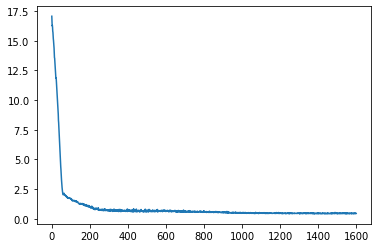

In [11]:
EPOCH = 100
train_res_recon_error = []
train_res_perplexity = []

loss_list = []
val_loss_list = []
ac_list = []
VQ_VAE.train()

for epoch in tqdm(range(EPOCH)):
    running_loss = 0.0
    count = 0
    quantized_merge = torch.empty(0, 1, 64).to(DEVICE)

    for _, (inputs1, inputs2) in enumerate(train_dataloader, 0):
        optimizer.zero_grad()
        inputs1 = inputs1.to(DEVICE)
        inputs2 = inputs2.to(DEVICE)
        vq_loss_b, vq_loss_t, recon_b, recon_b2, recon_t, z_b, z_final, quantized_b, perplexity, variance_z_b = VQ_VAE(inputs1, inputs2)
        recon_error_b = F.mse_loss(recon_b, inputs1) / data_variance_1
        recon_error_b2 = F.mse_loss(recon_b2, inputs2) / data_variance_2
        recon_error_t = F.mse_loss(recon_t, z_b) / variance_z_b
        loss = recon_error_b + recon_error_b2 + recon_error_t + vq_loss_b + vq_loss_t
        loss.backward()
        optimizer.step()
        count += 1

        # Append the training loss values for monitoring
        train_res_recon_error.append(recon_error_b.item() + recon_error_t.item())
        train_res_perplexity.append(perplexity.item())

        # Print training statistics
        if count % 5 == 0:  # Adjust this frequency as needed
            print(  f'Epoch [{epoch + 1}/{EPOCH}],'
                    f'Recon Error: {recon_error_b.item() + recon_error_t.item():.4f}, '
                    f'Perplexity: {perplexity.item():.4f}')

# After training, you can print or log other relevant information as needed
print('Training completed.')
plt.plot(train_res_recon_error)

In [12]:
en_lat = []
en_quantized = []
en_labels = []

data_set = Mydatasets(data1 = dat_1, data2 = dat_2)
data_set = torch.utils.data.DataLoader(data_set, batch_size = 256, shuffle=True)

for i in range(len(dat_1)):
    en_data1 = data_set.dataset[i][0]
    en_data2 = data_set.dataset[i][1]

    _, _, _, _, _, latent_1, latent_2, _, _, _ = VQ_VAE(en_data1.view(1, 1, feature_num_1).float().to(DEVICE), en_data2.view(1, 1, feature_num_2).float().to(DEVICE))
    en_quantized.append(latent_2.cpu().detach().numpy())
    en_lat.append(latent_1.cpu().detach().numpy())
    en_quantized.append(latent_2.cpu().detach().numpy())

encode_out = np.array(en_lat)
encode_out = encode_out.reshape(len(dat_1), -1)
quantized_out = np.array(en_quantized)
quantized_out = quantized_out.reshape(len(dat_1), -1)
print('encode_out:', encode_out.shape)
print('quantized_out:', quantized_out.shape)

latent_Z = encode_out

encode_out: (4445, 64)
quantized_out: (4445, 128)


/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[0.43422043 0.35987177]
[3.4018903 2.8194075]


/Users/aygalic/Thesis/genome_analysis_parkinson/thesis_related/../src/utils/visualisation.py:198: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  a = axes[1].scatter(pca_result[:, 0], pca_result[:, 1], marker='o', cmap=my_cmap, c=colors, s=20)


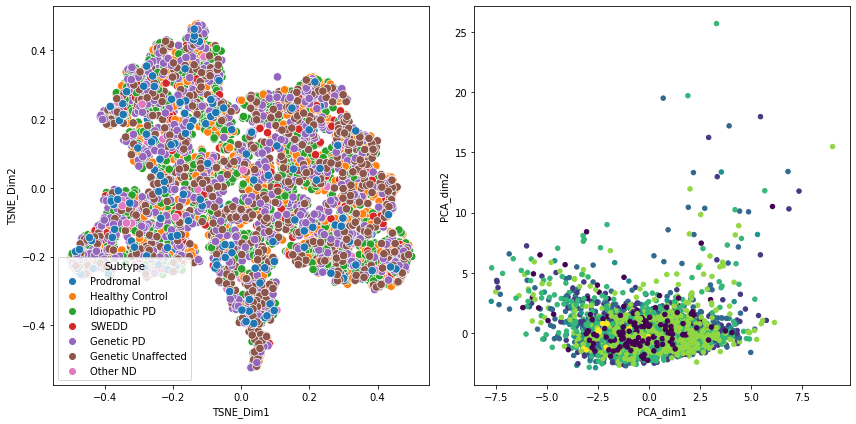

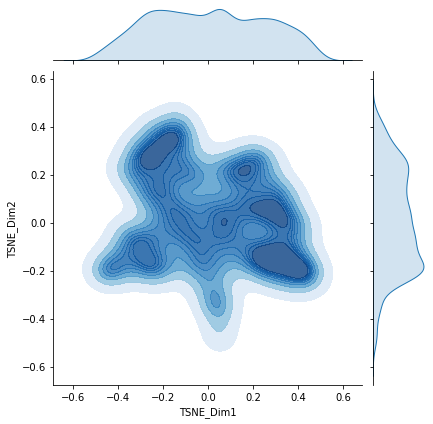

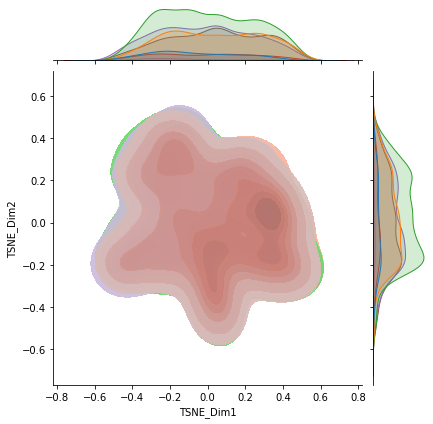

In [16]:
params = {"early_exaggeration":20,
              "learning_rate":500, 
              "perplexity":75, 
              "min_grad_norm":1e-7, 
              "n_iter":10000,
              "n_components":2}

visualisation.plot_clusters(encode_out, label, params)

In [17]:
# filtering data
# Convert clinical_info and filenames to Series for easy filtering
clinical_info_series = pd.Series(label)
filenames_series = pd.Series(filenames)

# Create boolean masks for filtering
#clinical_mask = clinical_info_series == "Genetic PD"
#clinical_mask = clinical_info_series == "Idiopathic PD"
filenames_mask = filenames_series.str.contains("BL")

# Combine the masks using logical AND
combined_mask = filenames_mask #& clinical_mask

# Apply the combined mask to your dataset
filtered_dat = encode_out[combined_mask]
#filtered_clinical_info = ["Genetic PD"]*sum(combined_mask)
#filtered_clinical_info = ["Idiopathic PD"]*sum(combined_mask)
filtered_clinical_info = clinical_info_series[combined_mask]

# Check the shape of the filtered dataset
print(filtered_dat.shape)
print(filtered_clinical_info.shape)

(1521, 64)
(1521,)


/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[0.4594276  0.34255192]
[3.677877  2.7422466]


/Users/aygalic/Thesis/genome_analysis_parkinson/thesis_related/../src/utils/visualisation.py:198: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  a = axes[1].scatter(pca_result[:, 0], pca_result[:, 1], marker='o', cmap=my_cmap, c=colors, s=20)


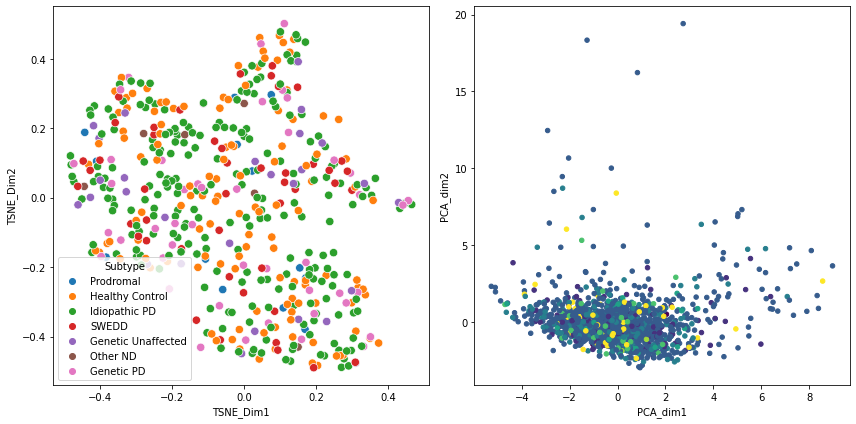

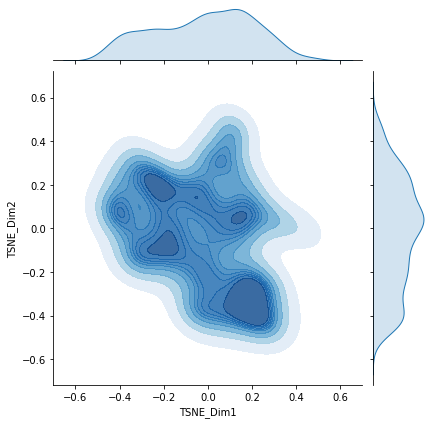

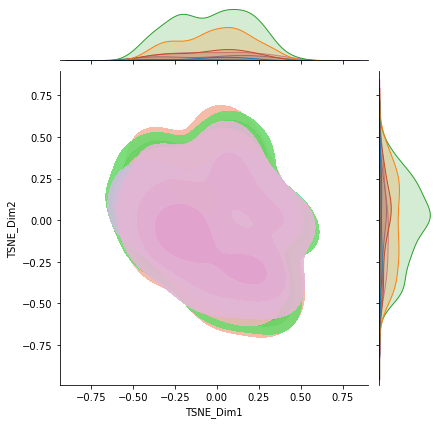

In [18]:
visualisation.plot_clusters(filtered_dat, filtered_clinical_info, params)

/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


TSNE_out: (4445, 2)


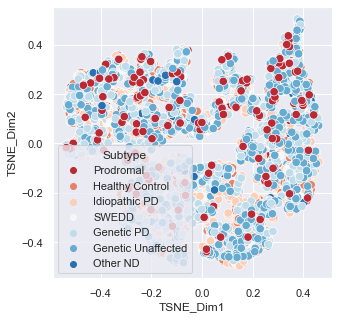

In [26]:
latent_Z = encode_out

tsne = TSNE(early_exaggeration=5,
              learning_rate=500, 
              perplexity=20, 
              min_grad_norm=1e-7, 
              n_iter=5000,
              n_components=2).fit_transform(latent_Z)
x_min, x_max = np.min(tsne, 0), np.max(tsne, 0)
tsne = tsne / (x_max - x_min)
print('TSNE_out:', tsne.shape)

TSNE_result = pd.DataFrame(tsne, columns=['TSNE_Dim1', 'TSNE_Dim2'])
TSNE_result['Subtype'] = label
#tsne of learened feature
plt.figure(figsize=(5,5))
sns.set(style='darkgrid',context='notebook')
sns.scatterplot(data = TSNE_result, x='TSNE_Dim1', y='TSNE_Dim2',hue='Subtype',palette='RdBu',s = 70)
plt.show()

[0.6317198 0.2677317]
[3.443346  1.4593381]
pca_result: (4445, 2)


/var/folders/xr/0fvz4r2s4wx1hx13jlhxj2z00000gn/T/ipykernel_2252/1427388129.py:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  a = plt.scatter(pca_result[:, 0], pca_result[:, 1], marker='o', cmap=my_cmap,c=colors,s=20)
/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/matplotlib/collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


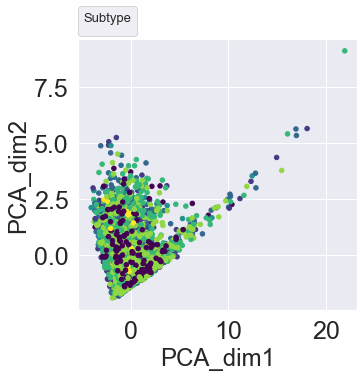

In [22]:
#PCA of learened feature
pca = PCA(n_components=2)
pca.fit(latent_Z)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_)
pca_result = pca.transform(latent_Z)
print('pca_result:',pca_result.shape)

sns.set(style='darkgrid',context='notebook')
plt.figure(figsize=(5,5)) 

my_cmap = plt.get_cmap('viridis', len(TSNE_result['Subtype'].unique()))
# Map string labels to numeric values
subtype_labels = TSNE_result['Subtype'].unique()
subtype_to_numeric = {subtype: i for i, subtype in enumerate(subtype_labels)}
colors = [my_cmap(subtype_to_numeric[subtype]) for subtype in TSNE_result['Subtype']]


a = plt.scatter(pca_result[:, 0], pca_result[:, 1], marker='o', cmap=my_cmap,c=colors,s=20)

L = plt.legend(*a.legend_elements(),
           borderaxespad = 1,
           title_fontsize = 13,
           fontsize = 13,
           loc = (0,1.01),
           ncol = 5,
           title="Subtype")
plt.xlabel("PCA_dim1", size=24)  
plt.ylabel("PCA_dim2", size=24)
plt.tick_params(axis='x', which='both', labelsize=25)
plt.tick_params(axis='y', which='both', labelsize=25)

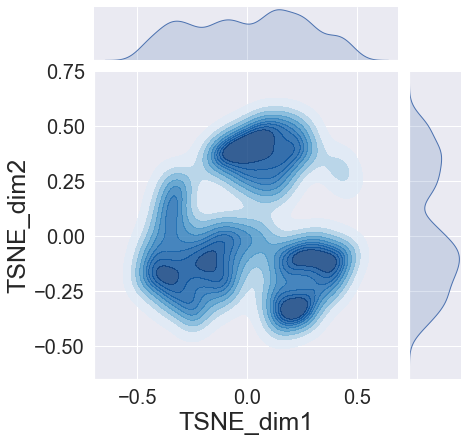

In [23]:
f = sns.jointplot(x=TSNE_result.TSNE_Dim1, y=TSNE_result.TSNE_Dim2, cmap="Blues", fill=True, kind='kde',height=6,
                 marginal_kws={"alpha":.2},thresh=0.05, alpha=.8)
f.ax_joint.set_xlabel("TSNE_dim1",fontsize=25)
f.ax_joint.set_ylabel("TSNE_dim2",fontsize=25)
f.ax_joint.tick_params(labelsize=20)

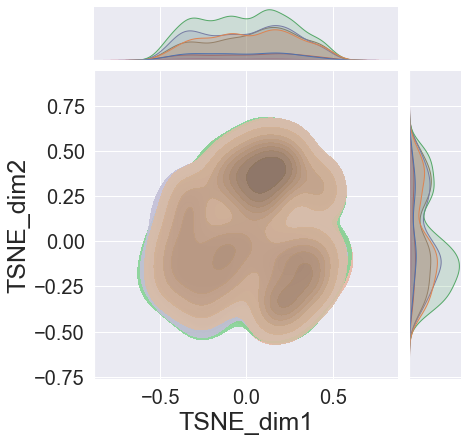

In [24]:
f = sns.jointplot(x=TSNE_result.TSNE_Dim1, y=TSNE_result.TSNE_Dim2, fill=True, kind='kde',hue=TSNE_result.Subtype,height=6,marginal_kws={"alpha":.2},thresh=0.05, alpha=.9)

f.ax_joint.legend_._visible=False
f.ax_joint.set_xlabel("TSNE_dim1",fontsize=25)
f.ax_joint.set_ylabel("TSNE_dim2",fontsize=25)
f.ax_joint.tick_params(labelsize=20)